<a href="https://colab.research.google.com/github/Shashank-Holla/TSAI-END-Program/blob/main/14-%20Capstone%20Project/EngtoPy_AttentionTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Transformer - English to Python machine translation 

In [1]:
!nvidia-smi

Sat Mar 27 10:58:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Necessary packages

In [2]:
!pip install torchtext==0.6.0

     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 1.2MB 26.0MB/s 
  Found existing installation: torchtext 0.9.0
    Uninstalling torchtext-0.9.0:
      Successfully uninstalled torchtext-0.9.0


In [3]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [4]:
# Import necessary packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext import data
# from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import pandas as pd

import random
import time
import math
import tokenize
import io
import shutil
import os

print(torchtext.__version__)

0.6.0


In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

## Data ingestion

Read input file and segregate English program directions to english list (source) and corresponding Python program/function to python list (target).

A line is considered a English question if a line starts with # and contains any of the following key word- write, python, program, function.

A line in between two such english question is considered as Python code.

In [6]:
# Read english-python file
with open('english_python_data.py','r') as fp_data:
    text = fp_data.readlines()

In [7]:
print("Number of lines:", len(text))
# print("Number of codes: ", len())
text[:10]

Number of lines: 35796


['# write a python program to add two numbers  and print the sum\n',
 'num1 = 1.5\n',
 'num2 = 6.3\n',
 'sum = num1 + num2\n',
 "print(f'Sum: {sum}')\n",
 '\n',
 '# write a python function to add two user provided numbers and return the sum\n',
 'def add_two_numbers(num1, num2):\n',
 '\tsum = num1 + num2\n',
 '\treturn sum\n']

In [8]:
# create english, python list
question_set = ['write', 'python', 'program', 'function', 'class']
english = []
python = []
_string = ''
for i in range(len(text)):
    if (text[i].startswith('#') and any(x in text[i].lower() for x in question_set)):
        # same_function = True
        english.append(text[i].strip('# \n'))
        if len(_string) !=0:
            python.append(_string)
            _string = ''
        continue
    # if same_function:
    _string += text[i]
python.append(_string)

In [9]:
print("Number of english questions: ", len(english))
print("Number of Python codes: ", len(python))

Number of english questions:  4242
Number of Python codes:  4242


In [10]:
# Sample english question and its corresponding Python code
print(english[151])
print(python[151])

write a python program to multiply two list with list comprehensive
l1=[1,2,3]
l2=[4,5,6]
print([x*y for x in l1 for y in l2])




In [11]:
# Tokenizer for python.
def tokenize_py(text):
    """
    Using tokenize package for tokenizing python code. Receives python code in string and returns tokens in a list.
    """
    return [token.string for token in tokenize.generate_tokens(io.StringIO(text).readline)]

In [12]:
# Tokenize python code and collect row ids of english-python code with python code length greater than 400
tokenized_python = []
for sentence in python:
    tokenized_python.append(tokenize_py(sentence))
ids_code_greater_than_400 = [i for i in range(len(tokenized_python)) if len(tokenized_python[i])>400]
print(ids_code_greater_than_400)

[605, 1139, 1148, 2383]


In [13]:
# dataframe with english and python set. Drop rows with python code length > 400.
dataset = {'english': english, 'python': python}
df = pd.DataFrame(dataset)
print(df.shape)
df.head()

(4242, 2)


,english,python
0,write a python program to add two numbers and...,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n\tsum = num1..."
2,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given lis...,"def merge_lists(l1, l2):\n\treturn l1 + l2\n\n"


In [14]:
df.drop(ids_code_greater_than_400, inplace=True)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(4238, 2)


,english,python
0,write a python program to add two numbers and...,num1 = 1.5\nnum2 = 6.3\nsum = num1 + num2\npri...
1,write a python function to add two user provid...,"def add_two_numbers(num1, num2):\n\tsum = num1..."
2,write a program to find and print the largest ...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 >= n...
3,write a program to find and print the smallest...,num1 = 10\nnum2 = 12\nnum3 = 14\nif (num1 <= n...
4,Write a python function to merge two given lis...,"def merge_lists(l1, l2):\n\treturn l1 + l2\n\n"


## Data preprocessing

### Spacy model for english (source)

In [15]:
# Download and load spacy models for EN languages. To be used for tokenization.
%%bash
python -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [16]:
# After linking spacy.load('en_core_web_sm') -> spacy.load('en')
spacy_en = spacy.load('en')

In [17]:
# Tokenizer for english
def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

### Prepare fields and dataset

In [18]:
ENGLISH = Field(tokenize = tokenize_en, init_token = '<SOS>', eos_token = '<EOS>', lower = True, batch_first = True)
PYTHON = Field(tokenize = tokenize_py, init_token = '<SOS>', eos_token = '<EOS>', lower = True, batch_first = True)

In [19]:
print(type(ENGLISH))
ENGLISH.__dict__

<class 'torchtext.data.field.Field'>


{'batch_first': True,
 'dtype': torch.int64,
 'eos_token': '<EOS>',
 'fix_length': None,
 'include_lengths': False,
 'init_token': '<SOS>',
 'is_target': False,
 'lower': True,
 'pad_first': False,
 'pad_token': '<pad>',
 'postprocessing': None,
 'preprocessing': None,
 'sequential': True,
 'stop_words': None,
 'tokenize': <function __main__.tokenize_en>,
 'tokenizer_args': (<function __main__.tokenize_en>, 'en'),
 'truncate_first': False,
 'unk_token': '<unk>',
 'use_vocab': True}

In [20]:
# Create a list of (name, field) pairs as the fields argument. 
# The fields we pass in must be in the same order as the columns
fields = [('english', ENGLISH), ('python', PYTHON)]

In [21]:
example = [data.Example.fromlist([df.english[i],df.python[i]], fields) for i in range(df.shape[0])] 

In [22]:
print(type(example))
print(len(example))
print(example)

<class 'list'>
4238
[<torchtext.data.example.Example object at 0x7f3941bc6f90>, <torchtext.data.example.Example object at 0x7f3941bc6fd0>, <torchtext.data.example.Example object at 0x7f3944008710>, <torchtext.data.example.Example object at 0x7f3941bd1050>, <torchtext.data.example.Example object at 0x7f3941bd1150>, <torchtext.data.example.Example object at 0x7f3941bd10d0>, <torchtext.data.example.Example object at 0x7f3941bd3950>, <torchtext.data.example.Example object at 0x7f3941bd3550>, <torchtext.data.example.Example object at 0x7f3941bd3990>, <torchtext.data.example.Example object at 0x7f3941bd9b50>, <torchtext.data.example.Example object at 0x7f3941bd72d0>, <torchtext.data.example.Example object at 0x7f3941bd76d0>, <torchtext.data.example.Example object at 0x7f3941bd7710>, <torchtext.data.example.Example object at 0x7f39433a8d90>, <torchtext.data.example.Example object at 0x7f3941bda850>, <torchtext.data.example.Example object at 0x7f3941bd7390>, <torchtext.data.example.Example obj

In [23]:
# Creating dataset
EngToPyDataset = data.Dataset(example, fields)

In [24]:
# Split dataset into train (70%), test (15%) and validation (15%)
train_data, test_data, valid_data = EngToPyDataset.split(split_ratio=[0.7, 0.15, 0.15], random_state=random.seed(SEED))

In [25]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 2967
Number of validation examples: 636
Number of testing examples: 635


In [26]:
print(vars(train_data.examples[0]))

{'english': ['write', 'a', 'python', 'program', 'to', 'raise', 'a', 'runtimeerror', 'exception', '.'], 'python': ['raise', 'runtimeerror', '(', "'something wrong'", ')', '', '']}


### Build vocabulary for ENGLISH and PYTHON

In [27]:
ENGLISH.build_vocab(train_data, min_freq = 2)
PYTHON.build_vocab(train_data, min_freq = 2)

In [28]:
print(f"Unique tokens in english (source) vocabulary: {len(ENGLISH.vocab)}")
print(f"Unique tokens in python (target) vocabulary: {len(PYTHON.vocab)}")

Unique tokens in english (source) vocabulary: 1218
Unique tokens in python (target) vocabulary: 3198


In [29]:
# SRC.vocab dict has the following keys - freqs(provides word and its frequencies), itos(mapping of integer to string), 
# stoi(mapping of string to its integer) and vectors()
print(ENGLISH.vocab.__dict__.keys())
PYTHON.vocab.__dict__

dict_keys(['freqs', 'itos', 'unk_index', 'stoi', 'vectors'])


{'freqs': Counter({'raise': 47,
          'runtimeerror': 2,
          '(': 12119,
          "'something wrong'": 2,
          ')': 12119,
          '': 10702,
          'n': 1321,
          '=': 6248,
          '8': 272,
          '\n': 15279,
          'd': 300,
          'dict': 113,
          'for': 1501,
          'i': 2028,
          'in': 1671,
          'range': 618,
          '1': 2295,
          ',': 8813,
          '+': 1429,
          ':': 6710,
          '\t': 2362,
          '[': 3572,
          ']': 3572,
          '*': 821,
          'print': 2509,
          'r1': 8,
          'r2': 14,
          '28': 6,
          '_': 21,
          'if': 1367,
          '%': 467,
          '2': 1303,
          '==': 828,
          '0': 1611,
          '\t\t': 1811,
          'def': 1754,
          'check_words': 1,
          'fname': 35,
          'input': 324,
          '"file name: "': 2,
          'num_words': 15,
          'with': 45,
          'open': 52,
          "'r'": 32,
   

### Create iterators for train, valid and test.

In [30]:
BATCH_SIZE = 32
# Adding sort argument for issue TypeError: '<' not supported between instances of 'Example' and 'Example'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), 
                                                       sort=False,
                                                       batch_size = BATCH_SIZE, 
                                                       device = device)

device

device(type='cuda')

In [31]:
batch = next(iter(train_iterator))
print(batch,"\n")
print(f"Source sequence of shape [batch_size, src_len]-{batch.python.shape} \n",batch.english[0])
print(f"Target of shape [batch_size, src_len]-{batch.python.shape} \n",batch.python[0])

# Index     String
#    0       <UNK>
#    1       <pad>
#    2       <SOS>
#    3       <EOS>
#    4         .


[torchtext.data.batch.Batch of size 32]
	[.english]:[torch.cuda.LongTensor of size 32x35 (GPU 0)]
	[.python]:[torch.cuda.LongTensor of size 32x242 (GPU 0)] 

Source sequence of shape [batch_size, src_len]-torch.Size([32, 242]) 
 tensor([  2,   5,   4,   7,  11,   6,   5,   4,   9,  35, 222, 112,   4, 172,
         19,  36, 743, 540,  14,   8, 535,  10, 539,  18,  24,  88,  22, 539,
         12, 540,   3,   1,   1,   1,   1], device='cuda:0')
Target of shape [batch_size, src_len]-torch.Size([32, 242]) 
 tensor([   2,   19,  915,    5,  160,    8,  206,    6,    9,    4,   14,  665,
          10,   58,    5,   35,    5,  160,    6,   63,   27,    6,    4,  996,
          10,  160,   11,    9,  665,    9,   12,   24,  206,   24,  160,   11,
         665,    9,   12,    4,   13,    5, 1591,    8,  996,    6,    4,    7,
         915,    5, 1593,    8,  511,    6,    7,    7,    3,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           

## Build Model

### Encoder

In [32]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_lengths = 310):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_lengths, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):
        # src = [batch_size, src_len]
        # src_mask = [batch_size, 1, 1, src_len] This is to keep the source sentence and ignore padding tokens.
        batch_size = src.shape[0]
        src_len = src.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        # pos = [batch_size, src_len]
        src = self.dropout(self.tok_embedding(src) * self.scale + self.pos_embedding(pos))
        # src = [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
            # src = [batch_size, src_len, hid_dim]
        
        return src

#### Encoder layer

In [33]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src, src_mask):
        # src = [batch_size, src_len, hid_dim]
        # src_mask = [batch_size, 1, 1, src_len]

        _src, _ = self.self_attention(src, src, src, src_mask)
        
        # dropout, residual connection and layer normalization
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        #src = [batch_size, src_len, hid_dim]
        
        # positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        # dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))        
        #src = [batch_size, src_len, hid_dim]
        
        return src   

#### Multihead attention layer

In [34]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        batch_size = query.shape[0]
        # query = [batch_size, query_len, hid_dim]
        # key = [batch_size, key_len, hid_dim]
        # value = [batch_size, value_len, hid_dim]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        # Q = [batch_size, query_len, hid_dim]
        # K = [batch_size, key_len, hid_dim]
        # V = [batch_size, value_len, hid_dim]

        # Split the hid_dim of query, key and value into n_heads
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)

        # Energy (unnormalized attention)
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #energy = [batch_size, n_heads, query_len, key_len]

        # mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)                
        # attention = [batch_size, n_heads, query_len, key_len]
                
        x = torch.matmul(self.dropout(attention), V)        
        # x = [batch_size, n_heads, query_len, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()        
        # x = [batch_size, query_len, n_heads, head_dim]
        
        x = x.view(batch_size, -1, self.hid_dim)        
        # x = [batch_size, query_len, hid_dim]
        
        x = self.fc_o(x)        
        # x = [batch_size, query_len, hid_dim]
        
        return x, attention

#### Position-wise Feed forward layer

In [35]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):        
        # x = [batch_size, seq_len, hid_dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))        
        # x = [batch_size, seq_len, pf_dim]
        
        x = self.fc_2(x)        
        # x = [batch_size, seq_len, hid_dim]
        
        return x

### Decoder

In [36]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 400):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        # trg = [batch_size, trg_len]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)                            
        # pos = [batch_size, trg_len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))                
        # trg = [batch_size, trg_len, hid_dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        # trg = [batch_size, trg_len, hid_dim]
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        output = self.fc_out(trg)        
        # output = [batch_size, trg_len, output_dim]
            
        return output, attention

#### Decoder layer

In [37]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):        
        # trg = [batch_size, trg_len, hid_dim]
        # enc_src = [batch_size, src_len, hid_dim]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        # src_mask = [batch_size, 1, 1, src_len]
        
        # self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))            
        # trg = [batch_size, trg_len, hid_dim]
            
        # encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        # trg = [batch_size, trg_len, hid_dim]
        
        # positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        # dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        # trg = [batch_size, trg_len, hid_dim]
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        return trg, attention

## Seq2Seq

In [38]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):        
        # src = [batch_size, src_len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # src_mask = [batch_size, 1, 1, src_len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        # trg = [batch_size, trg_len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)        
        # trg_pad_mask = [batch_size, 1, 1, trg_len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()        
        # trg_sub_mask = [trg_len, trg_len]
            
        trg_mask = trg_pad_mask & trg_sub_mask        
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        
        return trg_mask

    def forward(self, src, trg):
        
        # src = [batch_size, src_len]
        # trg = [batch_size, trg_len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        # src_mask = [batch_size, 1, 1, src_len]
        # trg_mask = [batch_size, 1, trg_len, trg_len]
        
        enc_src = self.encoder(src, src_mask)        
        # enc_src = [batch_size, src_len, hid_dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)        
        # output = [batch_size, trg_len, output_dim]
        # attention = [batch_size, n_heads, trg_len, src_len]
        
        return output, attention

## Training Seq2Seq

In [39]:
INPUT_DIM = len(ENGLISH.vocab)
OUTPUT_DIM = len(PYTHON.vocab)
HID_DIM = 512
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 1024
DEC_PF_DIM = 1024
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

print("Input dimension: ", INPUT_DIM)
print("Output dimension: ", OUTPUT_DIM)

enc = Encoder(INPUT_DIM, HID_DIM, ENC_LAYERS, ENC_HEADS, ENC_PF_DIM, ENC_DROPOUT, device)

dec = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS,DEC_PF_DIM, DEC_DROPOUT, device)

Input dimension:  1218
Output dimension:  3198


In [40]:
ENGLISH_PAD_IDX = ENGLISH.vocab.stoi[ENGLISH.pad_token]
PYTHON_PAD_IDX = PYTHON.vocab.stoi[PYTHON.pad_token]

model = Seq2Seq(enc, dec, ENGLISH_PAD_IDX, PYTHON_PAD_IDX, device).to(device)

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 20,036,734 trainable parameters


#### Weight initialization

In [42]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [43]:
model.apply(initialize_weights);

#### Define optimizer and criterion

In [44]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [45]:
criterion = nn.CrossEntropyLoss(ignore_index = PYTHON_PAD_IDX)
# criterion = nn.KLDivLoss()

## Train loop

In [46]:
def train(model, iterator, optimizer, criterion, clip):    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):        
        src = batch.english
        trg = batch.python
        
        optimizer.zero_grad() 

        output, _ = model(src, trg[:,:-1])                
        # output = [batch_size, trg_len - 1, output_dim]
        # trg = [batch_size, trg_len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)                
        # output = [batch_size * trg_len - 1, output_dim]
        # trg = [batch_size * trg_len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [47]:
def evaluate(model, iterator, criterion):    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():    
        for i, batch in enumerate(iterator):
            src = batch.english
            trg = batch.python

            output, _ = model(src, trg[:,:-1])            
            # output = [batch_size, trg_len - 1, output_dim]
            # trg = [batch_size, trg_len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)            
            # output = [batch_size * trg_len - 1, output_dim]
            # trg = [batch_size * trg_len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [48]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [49]:
train_loss_all = []
valid_loss_all = []

In [50]:
N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'english-python.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 16s
	Train Loss: 3.811 | Train PPL:  45.199
	 Val. Loss: 2.565 |  Val. PPL:  12.996
Epoch: 02 | Time: 0m 16s
	Train Loss: 2.464 | Train PPL:  11.757
	 Val. Loss: 2.072 |  Val. PPL:   7.942
Epoch: 03 | Time: 0m 16s
	Train Loss: 2.034 | Train PPL:   7.645
	 Val. Loss: 1.807 |  Val. PPL:   6.093
Epoch: 04 | Time: 0m 16s
	Train Loss: 1.745 | Train PPL:   5.726
	 Val. Loss: 1.653 |  Val. PPL:   5.224
Epoch: 05 | Time: 0m 17s
	Train Loss: 1.509 | Train PPL:   4.521
	 Val. Loss: 1.480 |  Val. PPL:   4.394
Epoch: 06 | Time: 0m 17s
	Train Loss: 1.323 | Train PPL:   3.753
	 Val. Loss: 1.399 |  Val. PPL:   4.052
Epoch: 07 | Time: 0m 17s
	Train Loss: 1.161 | Train PPL:   3.194
	 Val. Loss: 1.343 |  Val. PPL:   3.831
Epoch: 08 | Time: 0m 17s
	Train Loss: 1.032 | Train PPL:   2.806
	 Val. Loss: 1.246 |  Val. PPL:   3.476
Epoch: 09 | Time: 0m 16s
	Train Loss: 0.927 | Train PPL:   2.527
	 Val. Loss: 1.232 |  Val. PPL:   3.429
Epoch: 10 | Time: 0m 17s
	Train Loss: 0.836 | Train PPL

In [51]:
# gdrive_path = '/gdrive/MyDrive/ColabNotebooks/SchoolOfAI/END/14_capstone/models'
# shutil.copy('english-python.pt', gdrive_path)

In [52]:
# gdrive_path = 'drive/MyDrive/ColabNotebooks/SchoolOfAI/END/14_capstone/models'
# shutil.copy(os.path.join(gdrive_path, 'english-python.pt'), os.getcwd())

In [53]:
model.load_state_dict(torch.load('english-python.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.040 | Test PPL:   2.829 |


## Results

### Train/val loss graph

In [54]:
import matplotlib.pyplot as plt
def train_test_metrics_graph(train_loss_all, val_loss_all):

    plt.plot(train_loss_all, label="Train Loss")
    plt.plot(val_loss_all, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.title("Loss vs Epoch curve")

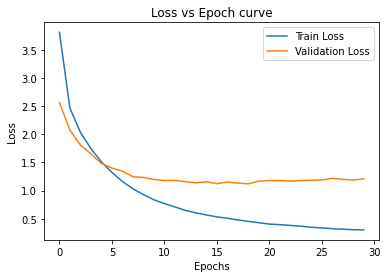

In [55]:
train_test_metrics_graph(train_loss_all, valid_loss_all)

### Inference

In [56]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 400):    
    model.eval()        
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)        
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]    
    return trg_tokens[1:], attention

In [57]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):    
    assert n_rows * n_cols == n_heads    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [58]:
def print_python_code(python_list):
    python_string = " "
    return (python_string.join(python_list))

#### Inference on training examples

In [ ]:
# idx = 500, 
example_idx = 500

src = vars(train_data.examples[example_idx])['english']
trg = vars(train_data.examples[example_idx])['python']

print(f'src = {src}')
print(f'trg = {trg}')
print(print_python_code(src))
print(print_python_code(trg))

src = ['write', 'a', 'function', 'to', 'reverse', 'words', 'of', 'string']
trg = ['def', 'rev_sentence', '(', 'sentence', ')', ':', '\n', '\t', 'words', '=', 'sentence', '.', 'split', '(', "' '", ')', '\n', 'reverse_sentence', '=', "' '", '.', 'join', '(', 'reversed', '(', 'words', ')', ')', '\n', 'return', 'reverse_sentence', '', '', '']
write a function to reverse words of string
def rev_sentence ( sentence ) : 
 	 words = sentence . split ( ' ' ) 
 reverse_sentence = ' ' . join ( reversed ( words ) ) 
 return reverse_sentence   


In [ ]:
translation, attention = translate_sentence(src, ENGLISH, PYTHON, model, device)

print(f'predicted trg = {translation}')
print(print_python_code(translation[:-2]))

predicted trg = ['def', 'rev_sentence', '(', 'sentence', ')', ':', '\n', '\t', 'words', '=', 'sentence', '.', 'split', '(', "' '", ')', '\n', 'reverse_sentence', '=', "' '", '.', 'join', '(', 'reversed', '(', 'words', ')', ')', '\n', 'return', 'reverse_sentence', '', '', '', '<EOS>']
def rev_sentence ( sentence ) : 
 	 words = sentence . split ( ' ' ) 
 reverse_sentence = ' ' . join ( reversed ( words ) ) 
 return reverse_sentence  


In [60]:
id_to_check = [500, 400, 200, 300, 615]
for i, id in enumerate(id_to_check):
    src = vars(train_data.examples[id])['english']
    trg = vars(train_data.examples[id])['python']
    translation, attention = translate_sentence(src, ENGLISH, PYTHON, model, device)
    print(f"Q{i+1}: ", print_python_code(src))
    print("--------Actual-----------")
    print(print_python_code(trg))
    print("--------Predicted-----------")
    print(print_python_code(translation[:-2]))
    print("\n\n")

Q1:  write a function to reverse words of string
--------Actual-----------
def rev_sentence ( sentence ) : 
 	 words = sentence . split ( ' ' ) 
 reverse_sentence = ' ' . join ( reversed ( words ) ) 
 return reverse_sentence   
--------Predicted-----------
def rev_sentence ( sentence ) : 
 	 words = sentence . split ( ' ' ) 
 reverse_sentence = ' ' . join ( reversed ( words ) ) 
 return reverse_sentence  



Q2:  write a python function to display the fibonacci series
--------Actual-----------
def recur_fibo ( n ) : 
 	 if n <= 1 : 
 		 return n 
  else : 
 		 return ( recur_fibo ( n - 1 ) + recur_fibo ( n - 2 ) )    
--------Predicted-----------
def fib ( limit ) : 
 	 a , b = 0 , 1 
 while a < limit : 
 		 yield a , b = b , a + b   



Q3:  write a python program to compute the product of every pair of numbers from two lists
--------Actual-----------
list1 = [ 1 , 2 , 3 ] 
 list2 = [ 5 , 6 , 7 ] 
 final = [ a * b for a in list1 for b in list2 ] 
 print ( f"product of every pair of nu

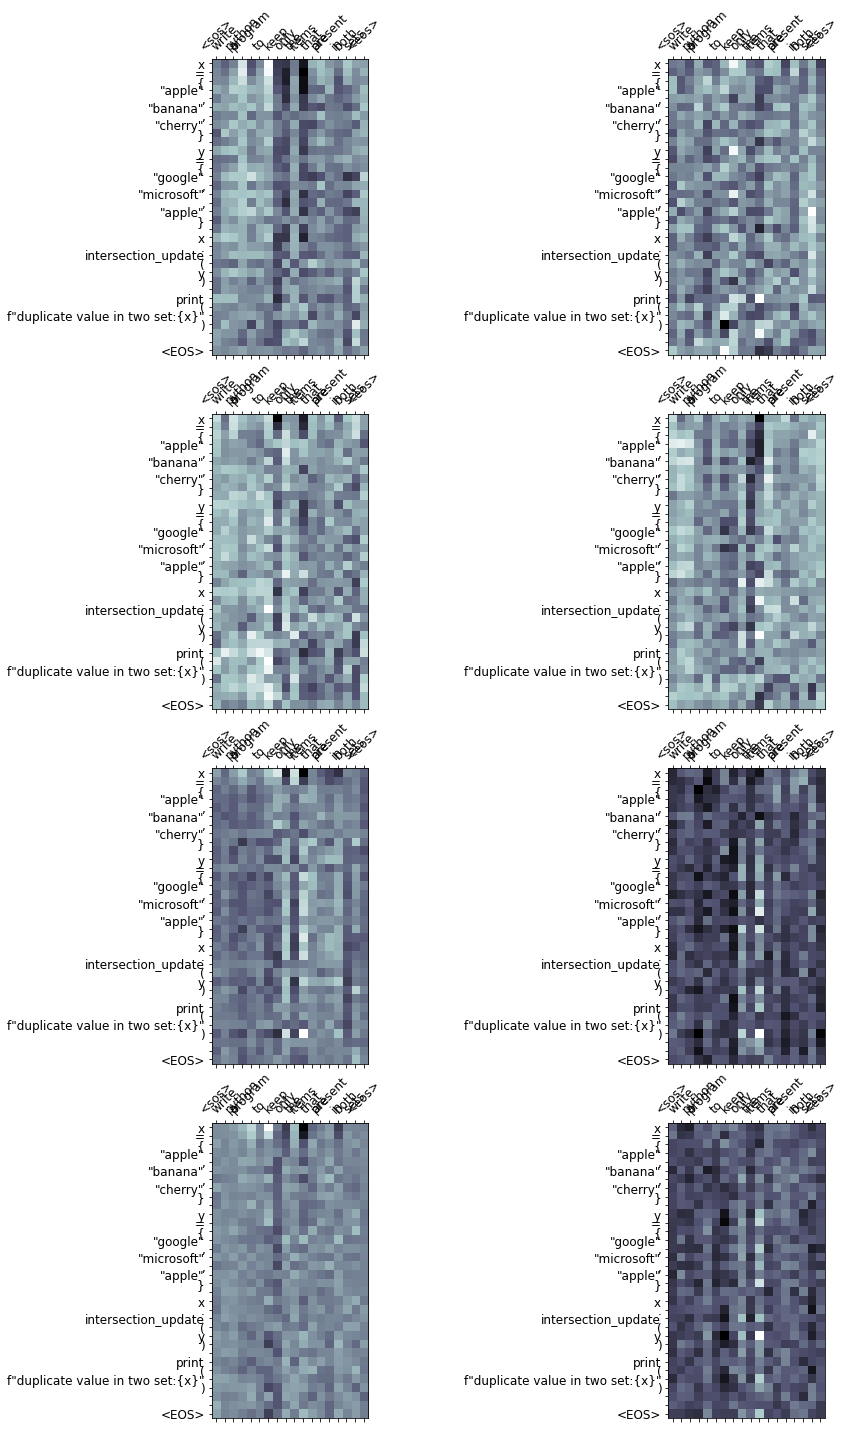

In [61]:
display_attention(src, translation, attention)

#### Inference on validation examples

In [62]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['english']
trg = vars(valid_data.examples[example_idx])['python']

print(f'src = {src}')
print(f'trg = {trg}')
print(print_python_code(trg))

src = ['write', 'a', 'function', 'to', 'calculate', 'volume', 'of', 'triangular', 'pyramid']
trg = ['def', 'volumetriangular', '(', 'a', ',', 'b', ',', 'h', ')', ':', '\n', '\t', 'return', '(', '0.1666', ')', '*', 'a', '*', 'b', '*', 'h', '\n', '', '']
def volumetriangular ( a , b , h ) : 
 	 return ( 0.1666 ) * a * b * h 
  


In [63]:
translation, attention = translate_sentence(src, ENGLISH, PYTHON, model, device)

print(f'predicted trg = {translation}')
print(print_python_code(translation[:-2]))

predicted trg = ['def', '<unk>', '(', 'a', ',', 'b', ',', 'h', ')', ':', '\n', '\t', 'return', '(', '<unk>', ')', '*', 'a', '*', 'b', '*', 'h', '\n', '', '', '', '<EOS>']
def <unk> ( a , b , h ) : 
 	 return ( <unk> ) * a * b * h 
  


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


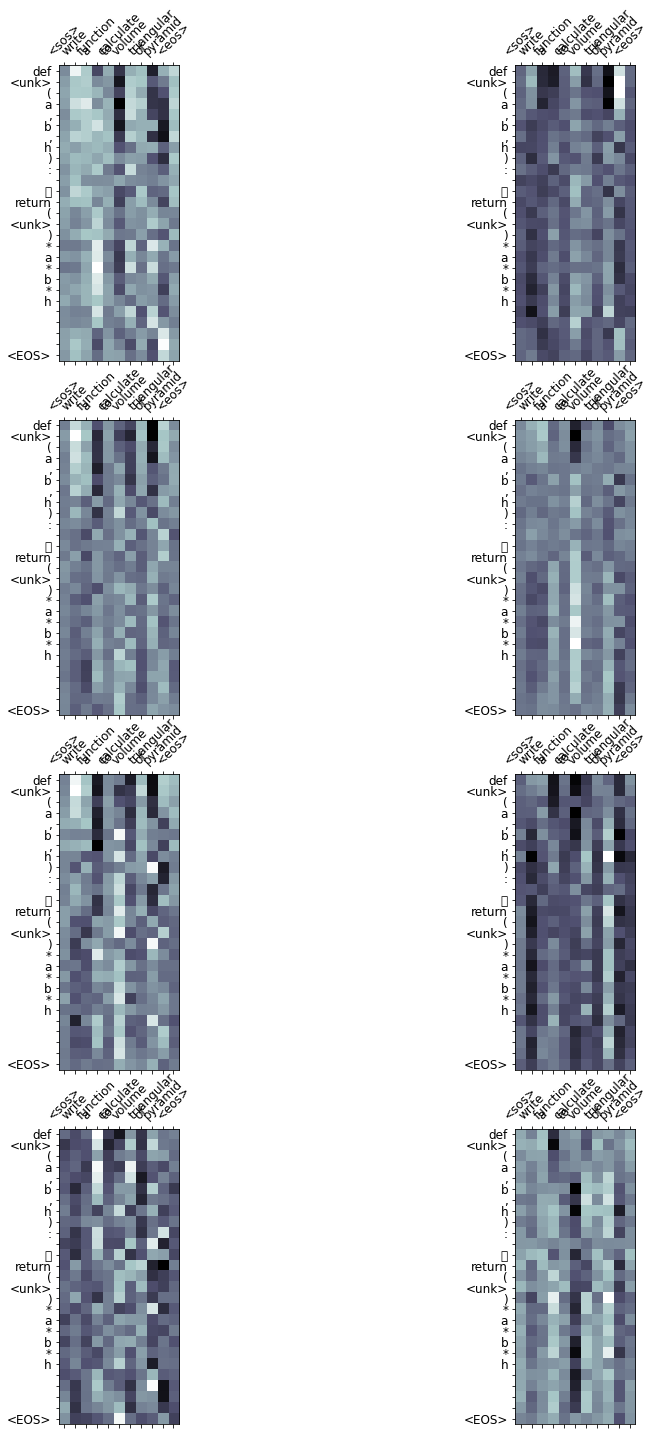

In [64]:
display_attention(src, translation, attention)

#### Inference on test examples

In [65]:
example_idx = 6

src = vars(test_data.examples[example_idx])['english']
trg = vars(test_data.examples[example_idx])['python']

print(f'src = {src}')
print(f'trg = {trg}')
print(print_python_code(trg))

src = ['write', 'a', 'list', 'comprehension', 'in', 'python', 'to', 'get', 'a', 'list', 'of', 'odd', 'numbers', 'when', 'a', 'range', 'is', 'given']
trg = ['n', '=', '20', '\n', 'number_list', '=', '[', 'x', 'for', 'x', 'in', 'range', '(', 'n', ')', 'if', 'x', '%', '2', '!=', '0', ']', '\n', 'print', '(', "f'list of odd numbers:'", ',', 'number_list', ')', '', '']
n = 20 
 number_list = [ x for x in range ( n ) if x % 2 != 0 ] 
 print ( f'list of odd numbers:' , number_list )  


In [66]:
translation, attention = translate_sentence(src, ENGLISH, PYTHON, model, device)

print(f'predicted trg = {translation}')
print(print_python_code(translation[:-2]))

predicted trg = ['nums', '=', '[', '1', ',', '2', ',', '3', ',', '4', ',', '5', ',', '6', ',', '7', ',', '8', ']', '\n', 'no_even_nums', '=', '[', 'i', 'for', 'i', 'in', 'nums', 'if', 'i', '%', '2', '==', '1', ']', '', '', '<EOS>']
nums = [ 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 ] 
 no_even_nums = [ i for i in nums if i % 2 == 1 ] 


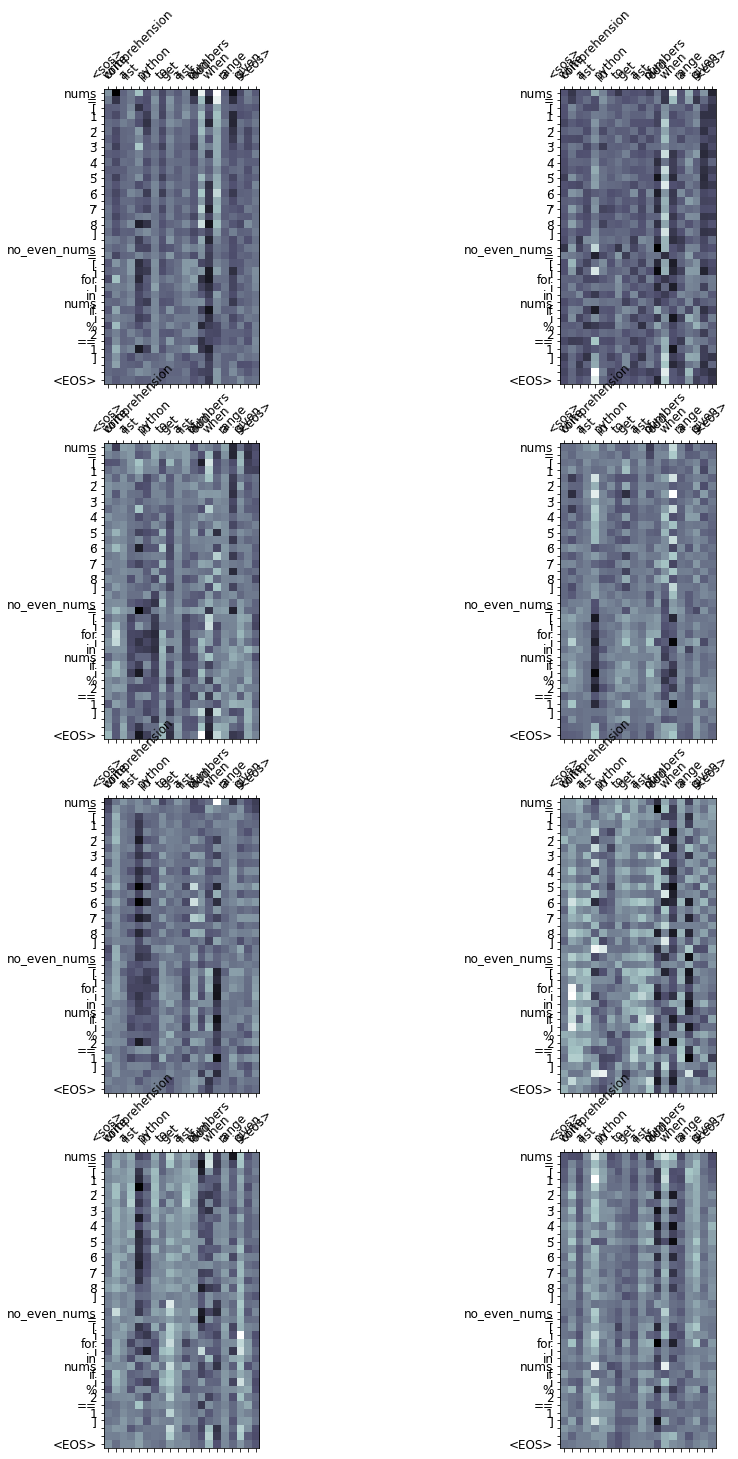

In [67]:
display_attention(src, translation, attention)

### Bleu score

In [ ]:
from torchtext.data.metrics import bleu_score
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 400):    
    trgs = []
    pred_trgs = []    
    for datum in data:        
        src = vars(datum)['english']
        trg = vars(datum)['python']        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, ENGLISH, PYTHON, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')